# RMIA (Robust Membership Inference Attack) with PrivacyGuard for CIFAR-10

## Introduction

This tutorial demonstrates how to use the Privacy Guard framework to perform Robust Membership Inference Attacks (RMIA) on machine learning models trained on the CIFAR-10 dataset. For more details, refer to the paper: https://arxiv.org/abs/2312.03262.

### What is a Robust Membership Inference Attack (RMIA)?

RMIA is an advanced membership inference attack that estimates population probability distributions using reference models and compares the target model's predictions against estimated population averages to determine membership. Unlike traditional attacks that rely on simple threshold-based approaches, RMIA uses a more sophisticated ratio-based scoring mechanism.

### Key Components of RMIA

- **Reference Models**: Multiple models trained without target samples to establish baseline behavior
- **Population Data**: Additional data samples used to estimate population probability distributions
- **Ratio-based Scoring**: Compares target model predictions to population averages for membership inference
- **Auto-tuning**: Automatic optimization of the alpha coefficient for improved performance

### What We'll Cover

In this tutorial, we will:
1. Set up the CIFAR-10 dataset and create training/testing splits
2. Train a target model and multiple reference models
3. Create population data for probability distribution estimation
4. Extract prediction scores from all models
5. Perform RMIA attack using Privacy Guard's `RmiaAttack` class
6. Analyze the attack results and evaluate privacy risks
7. Compare different parameter settings and their impact on attack effectiveness

Let's get started!

## Environment Set-Up


In [ ]:
# Optionally create a conda environment for installing packages.
# If executing from Google Colab, skip this step.
!conda create -n privacy_guard python=3.12
!conda activate privacy_guard


In [ ]:
%cd /content
!git clone https://github.com/facebookresearch/PrivacyGuard.git

In [ ]:
%cd /content/PrivacyGuard
!ls
!pip install -e .

## Setup and Imports

First, let's import the necessary libraries and set up our environment.

In [ ]:
from typing import Any, Dict, List, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from numpy.typing import NDArray

from privacy_guard.analysis.mia.aggregate_analysis_input import AggregationType
from privacy_guard.attacks.rmia_attack import RmiaAttack

from privacy_guard.shadow_model_training.dataset import (
    create_rmia_datasets,
    load_cifar10,
)
from privacy_guard.shadow_model_training.model import create_model
from privacy_guard.shadow_model_training.training import (
    get_softmax_scores,
    prepare_rmia_data,
    train_model,
)

from privacy_guard.shadow_model_training.visualization import (
    analyze_attack,
    plot_roc_curve,
    plot_score_distributions,
)

from torch.utils.data import DataLoader, Subset
from torchvision.datasets import CIFAR10

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Use CUDA if available
DEVICE: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

I0828 085841.650 _utils_internal.py:290] NCCL_DEBUG env var is set to None
I0828 085841.652 _utils_internal.py:299] NCCL_DEBUG is WARN from /etc/nccl.conf


Remapping module privacy_guard from /data/users/lucamelis/.bento/kernels/bento_kernel_empirical_dp/382/bento_kernel_empirical_dp_binary-inplace#link-tree/privacy_guard/__init__.py to /data/repos/fbsource/fbcode/privacy_guard/shadow_model_training/__init__.py
Remapping module privacy_guard.shadow_model_training.dataset from /data/users/lucamelis/.bento/kernels/bento_kernel_empirical_dp/382/bento_kernel_empirical_dp_binary-inplace#link-tree/privacy_guard/shadow_model_training/dataset.py to /data/repos/fbsource/fbcode/privacy_guard/shadow_model_training/dataset.py


I0828 085851.631 structured_logging.py:497] TritonTraceHandler: disabled because /logs does not exist


W0828 085851.633 triton_util.py:167] ===========[FB_TRITON]=========== Triton Version: 3.3.2+fb


Remapping module privacy_guard.shadow_model_training.training from /data/users/lucamelis/.bento/kernels/bento_kernel_empirical_dp/382/bento_kernel_empirical_dp_binary-inplace#link-tree/privacy_guard/shadow_model_training/training.py to /data/repos/fbsource/fbcode/privacy_guard/shadow_model_training/training.py


Using device: cuda


## Dataset Preparation

Now, let's load the CIFAR-10 dataset and prepare it for our experiments.

In [ ]:
# Load the dataset
train_dataset: CIFAR10
test_dataset: CIFAR10
train_dataset, test_dataset = load_cifar10()
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 50000
Test set size: 10000


## Creating Reference Datasets and Population Data

For RMIA, we need to create multiple reference datasets and population data. Each reference model will be trained on a different subset of the training data, and population data will be used to establish baseline probability distributions.

In [ ]:
# Create reference datasets (similar to shadow datasets but for RMIA)
num_references: int = 4  # More reference models for better population estimation
population_size: int = 10000  # Population size for RMIA

reference_datasets: List[Tuple[Subset, np.ndarray]]
target_dataset: Tuple[Subset, np.ndarray]
population_dataset: Subset
reference_datasets, target_dataset, population_dataset = create_rmia_datasets(
    train_dataset, test_dataset, num_references, population_size
)


Reference 0: 25030 in-samples
Reference 1: 25231 in-samples
Reference 2: 24779 in-samples
Target: 24960 in-samples
Population: 10000 samples


## Training Target and Reference Models
Let's train our target model and reference models. The target model will be evaluated for membership inference, while reference models help establish baseline behavior.

In [ ]:
# Create data loaders
batch_size: int = 256

test_loader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)
population_loader: DataLoader = DataLoader(
    population_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

EPOCHS: int = 50

# Train target model (using target_in samples)
print("Training target model...")
target_model: nn.Module = create_model().to(DEVICE)
target_in: Subset = target_dataset[0]
target_loader: DataLoader = DataLoader(
    target_in, batch_size=batch_size, shuffle=True, num_workers=2
)
target_model = train_model(
    target_model, target_loader, test_loader, epochs=EPOCHS, device=DEVICE
)

# Train reference models
reference_models: List[nn.Module] = []
for i, (ref_in, _) in enumerate(reference_datasets):
    print(f"Training reference model {i+1}/{len(reference_datasets)}...")
    ref_loader = DataLoader(ref_in, batch_size=batch_size, shuffle=True, num_workers=2)
    ref_model = create_model().to(DEVICE)
    ref_model = train_model(
        ref_model, ref_loader, test_loader, epochs=EPOCHS, device=DEVICE
    )
    reference_models.append(ref_model)

Training target model...
Epoch 1/50
Training - Loss: 1.9251, Acc: 26.22%
Testing - Acc: 33.12%
Epoch 2/50
Training - Loss: 1.5524, Acc: 41.25%
Testing - Acc: 47.03%
Epoch 3/50
Training - Loss: 1.3631, Acc: 49.58%
Testing - Acc: 51.54%
Epoch 4/50
Training - Loss: 1.2196, Acc: 55.70%
Testing - Acc: 58.83%
Epoch 5/50
Training - Loss: 1.0978, Acc: 60.55%
Testing - Acc: 60.68%
Epoch 6/50
Training - Loss: 1.0057, Acc: 64.30%
Testing - Acc: 64.01%
Epoch 7/50
Training - Loss: 0.9136, Acc: 67.38%
Testing - Acc: 63.27%
Epoch 8/50
Training - Loss: 0.8639, Acc: 69.07%
Testing - Acc: 67.05%
Epoch 9/50
Training - Loss: 0.7910, Acc: 72.04%
Testing - Acc: 68.27%
Epoch 10/50
Training - Loss: 0.7486, Acc: 73.43%
Testing - Acc: 68.48%
Epoch 11/50
Training - Loss: 0.6963, Acc: 75.54%
Testing - Acc: 70.58%
Epoch 12/50
Training - Loss: 0.6442, Acc: 77.48%
Testing - Acc: 75.83%
Epoch 13/50
Training - Loss: 0.6124, Acc: 78.63%
Testing - Acc: 73.13%
Epoch 14/50
Training - Loss: 0.5857, Acc: 79.91%
Testing - Ac

## Extracting Prediction Scores

Now, let's extract prediction scores from all models for the training data and population data. These scores will be used for the RMIA attack.

In [ ]:
temperature: float = 2.0
# Create a DataLoader for the entire training dataset (without shuffling)
train_eval_loader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

# Get scores from target model on training data
print("Getting scores from target model on training data...")
target_scores_train: NDArray[np.float64] = get_softmax_scores(
    target_model, train_eval_loader, temperature, DEVICE
)

# Get scores from target model on population data
print("Getting scores from target model on population data...")
target_scores_population: NDArray[np.float64] = get_softmax_scores(
    target_model, population_loader, temperature, DEVICE
)

# Get scores from reference models on training data
ref_scores_train_list: List[NDArray[np.float64]] = []
num_references = len(reference_models)
for i, ref_model in enumerate(reference_models):
    print(
        f"Getting scores from reference model {i+1}/{num_references} on training data..."
    )
    ref_scores_train_list.append(
        get_softmax_scores(ref_model, train_eval_loader, temperature, DEVICE)
    )

# Get scores from reference models on population data
ref_scores_population_list: List[NDArray[np.float64]] = []
for i, ref_model in enumerate(reference_models):
    print(
        f"Getting scores from reference model {i+1}/{num_references} on population data..."
    )
    ref_scores_population_list.append(
        get_softmax_scores(ref_model, population_loader, temperature, DEVICE)
    )

ref_scores_train: NDArray[np.float64] = np.array(ref_scores_train_list).squeeze().T
ref_scores_population: NDArray[np.float64] = (
    np.array(ref_scores_population_list).squeeze().T
)

Getting scores from target model on training data...
Getting scores from target model on population data...
Getting scores from reference model 1/3 on training data...
Getting scores from reference model 2/3 on training data...
Getting scores from reference model 3/3 on training data...
Getting scores from reference model 1/3 on population data...
Getting scores from reference model 2/3 on population data...
Getting scores from reference model 3/3 on population data...


## Preparing Data for RMIA Attack

Now, let's prepare the data in the format expected by the RMIA attack. We need to create dataframes with target scores, reference scores, and membership indicators.

In [ ]:
# Prepare data for RMIA attack
df_train_merge: pd.DataFrame
df_test_merge: pd.DataFrame
df_population: pd.DataFrame
df_train_merge, df_test_merge, df_population = prepare_rmia_data(
    target_scores_train,
    target_scores_population,
    ref_scores_train,
    ref_scores_population,
    target_dataset,
    reference_datasets,
)

print(f"Training data shape: {df_train_merge.shape}")
print(f"Testing data shape: {df_test_merge.shape}")
print(f"Population data shape: {df_population.shape}")
print(f"Training data columns: {list(df_train_merge.columns)}")

Training data shape: (24960, 8)
Testing data shape: (25040, 8)
Population data shape: (10000, 7)
Training data columns: ['user_id', 'score_orig', 'score_ref_0', 'member_ref_0', 'score_ref_1', 'member_ref_1', 'score_ref_2', 'member_ref_2']


## Performing RMIA Attack

Now, let's perform the RMIA attack using the Privacy Guard framework. We'll test different configurations to understand their impact.

In [ ]:
# Basic RMIA attack with default parameters
print("Running RMIA attack with default parameters...")
rmia_attack_default = RmiaAttack(
    df_train_merge=df_train_merge,
    df_test_merge=df_test_merge,
    df_population=df_population,
    row_aggregation=AggregationType.NONE,
    alpha_coefficient=0.3,
    num_reference_models=1,
    enable_auto_tuning=False,
)

# Run the attack
default_attack_results: Any = rmia_attack_default.run_attack()

# RMIA attack with auto-tuning enabled
print("Running RMIA attack with auto-tuning enabled...")
rmia_attack_tuned = RmiaAttack(
    df_train_merge=df_train_merge,
    df_test_merge=df_test_merge,
    df_population=df_population,
    row_aggregation=AggregationType.NONE,
    alpha_coefficient=0.3,  # Initial value, will be tuned
    num_reference_models=1,
    enable_auto_tuning=True,
)

# Run the attack with auto-tuning
tuned_attack_results: Any = rmia_attack_tuned.run_attack()

## Analyzing Attack Results

Let's analyze the results of our attacks using the analysis framework.

In [ ]:
# Analyze default attack
print("Analyzing default attack...")
default_analysis: Dict[str, Any] = analyze_attack(
    default_attack_results, "RMIA (Default)"
)

print("Analyzing tuned attack...")
# Analyze tuned attack
tuned_analysis: Dict[str, Any] = analyze_attack(
    tuned_attack_results, "RMIA (Auto-tuned)"
)

# Print comparison of AUC scores
print("\n=== Attack Performance Comparison ===")
print(f"Default RMIA AUC: {default_analysis.get('auc', 'N/A'):.4f}")
print(f"Auto-tuned RMIA AUC: {tuned_analysis.get('auc', 'N/A'):.4f}")


I0828 092246.602 analysis_node.py:193] Train/Test unique users: 24960/25040


Analyzing default attack...


I0828 092251.865 mia_results.py:247] TNR: 0.07804, FNR: 0.00617, emp eps: 2.25384, tnr@fnr0.001: 0.0, eps@fnr0.001: -0.00031, auc 0.5645 accuracy 0.5633, 


I0828 092251.868 analysis_node.py:202] Epsilon CI: 2.253840249352018


I0828 092318.647 analysis_node.py:193] Train/Test unique users: 24960/25040



RMIA (Default) Attack Results:
Attack Accuracy: 0.5640 (95% CI: [0.5611, 0.5671])
Attack AUC: 0.5673 (95% CI: [0.5625, 0.5723])
Epsilon at TPR=1% (Upper Bound): 1.7593
Epsilon at TPR=1% (Lower Bound): -0.7524
Analyzing tuned attack...


I0828 092324.010 mia_results.py:247] TNR: 0.01603, FNR: 0.0, emp eps: 3.84982, tnr@fnr0.001: 0.04135, eps@fnr0.001: 0.03697, auc 0.5679 accuracy 0.56911, 


I0828 092324.012 analysis_node.py:202] Epsilon CI: 3.849824610908012



RMIA (Auto-tuned) Attack Results:
Attack Accuracy: 0.5676 (95% CI: [0.5646, 0.5709])
Attack AUC: 0.5675 (95% CI: [0.5626, 0.5725])
Epsilon at TPR=1% (Upper Bound): 0.7002
Epsilon at TPR=1% (Lower Bound): -0.6961

=== Attack Performance Comparison ===
Default RMIA AUC: 0.5673
Auto-tuned RMIA AUC: 0.5675


## Visualizing Attack Results

Let's visualize the distribution of scores for members" and non-members for all attack variants.

<Figure size 1000x600 with 0 Axes>

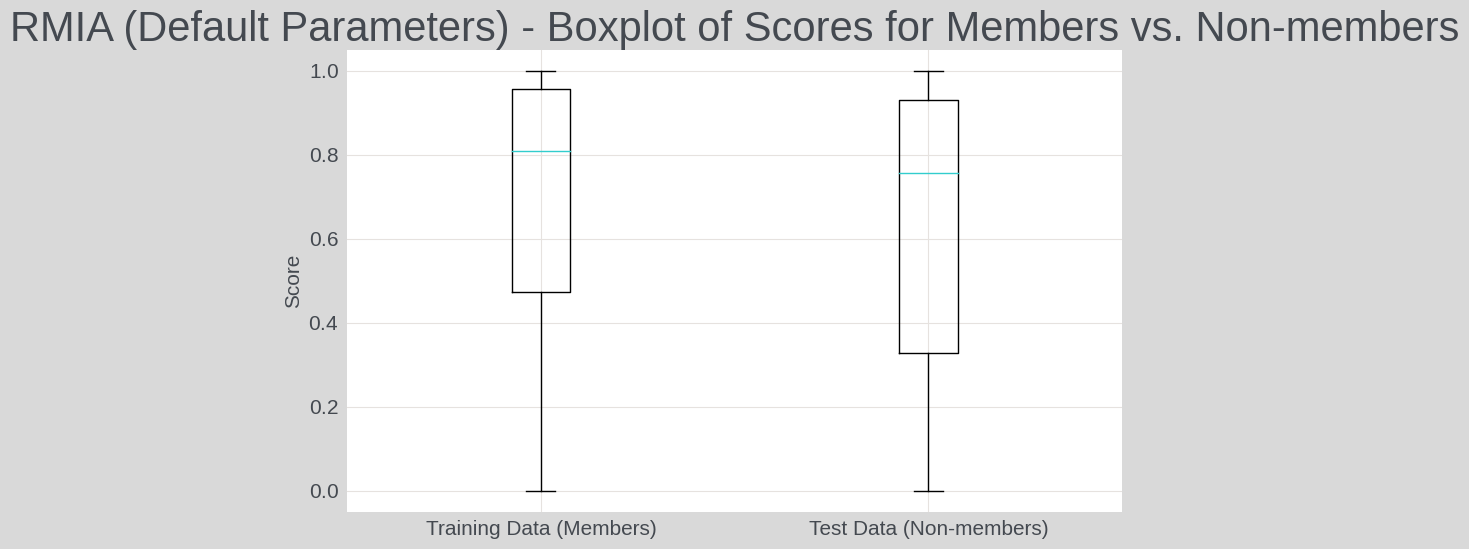

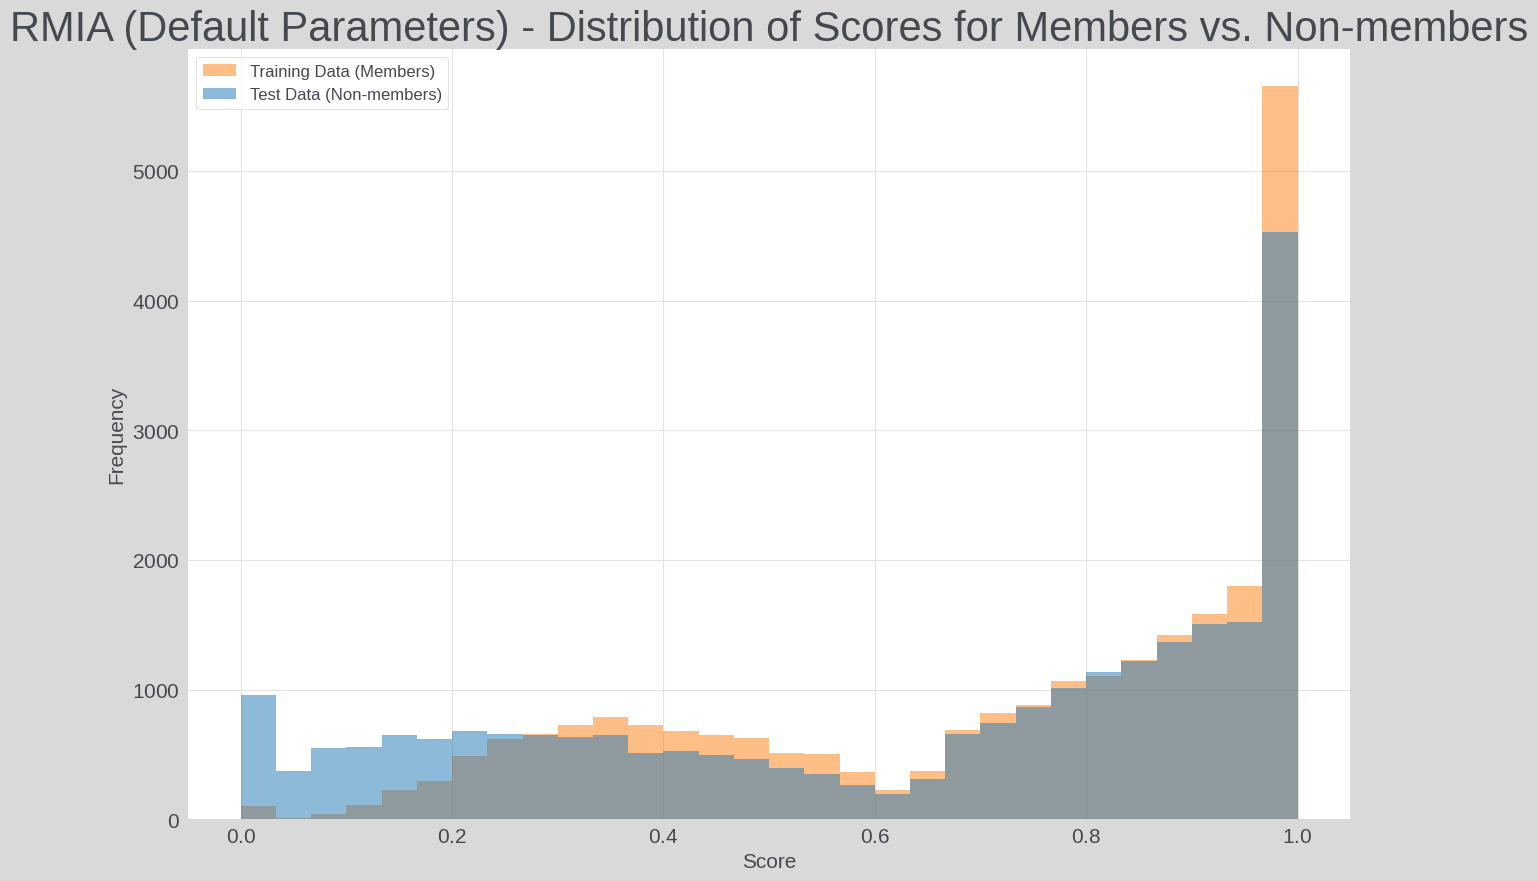

<Figure size 1000x600 with 0 Axes>

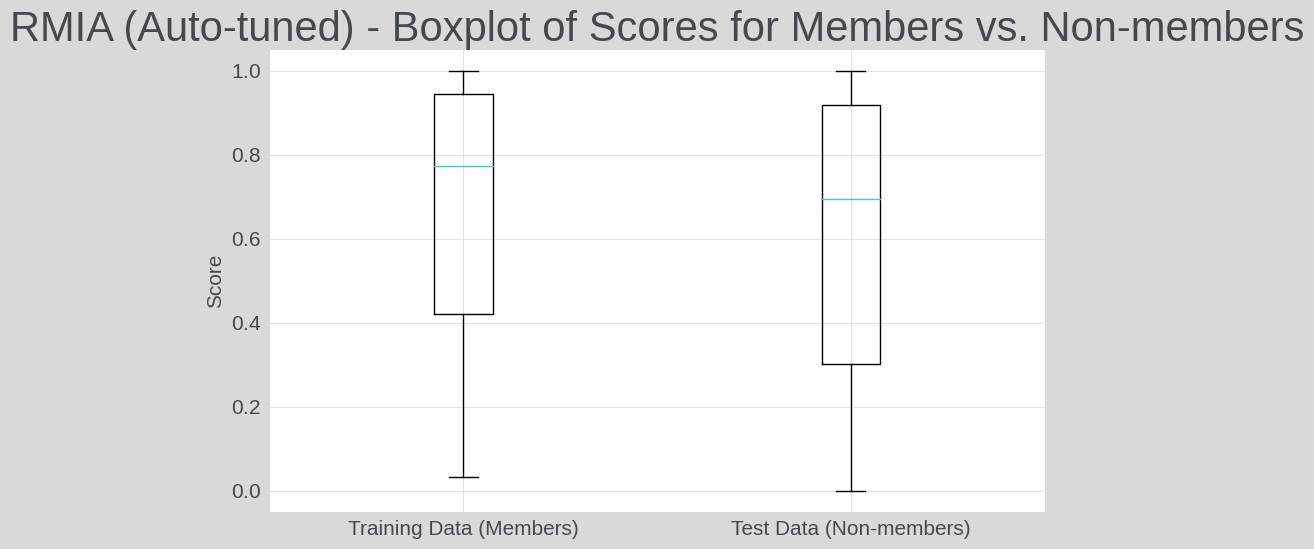

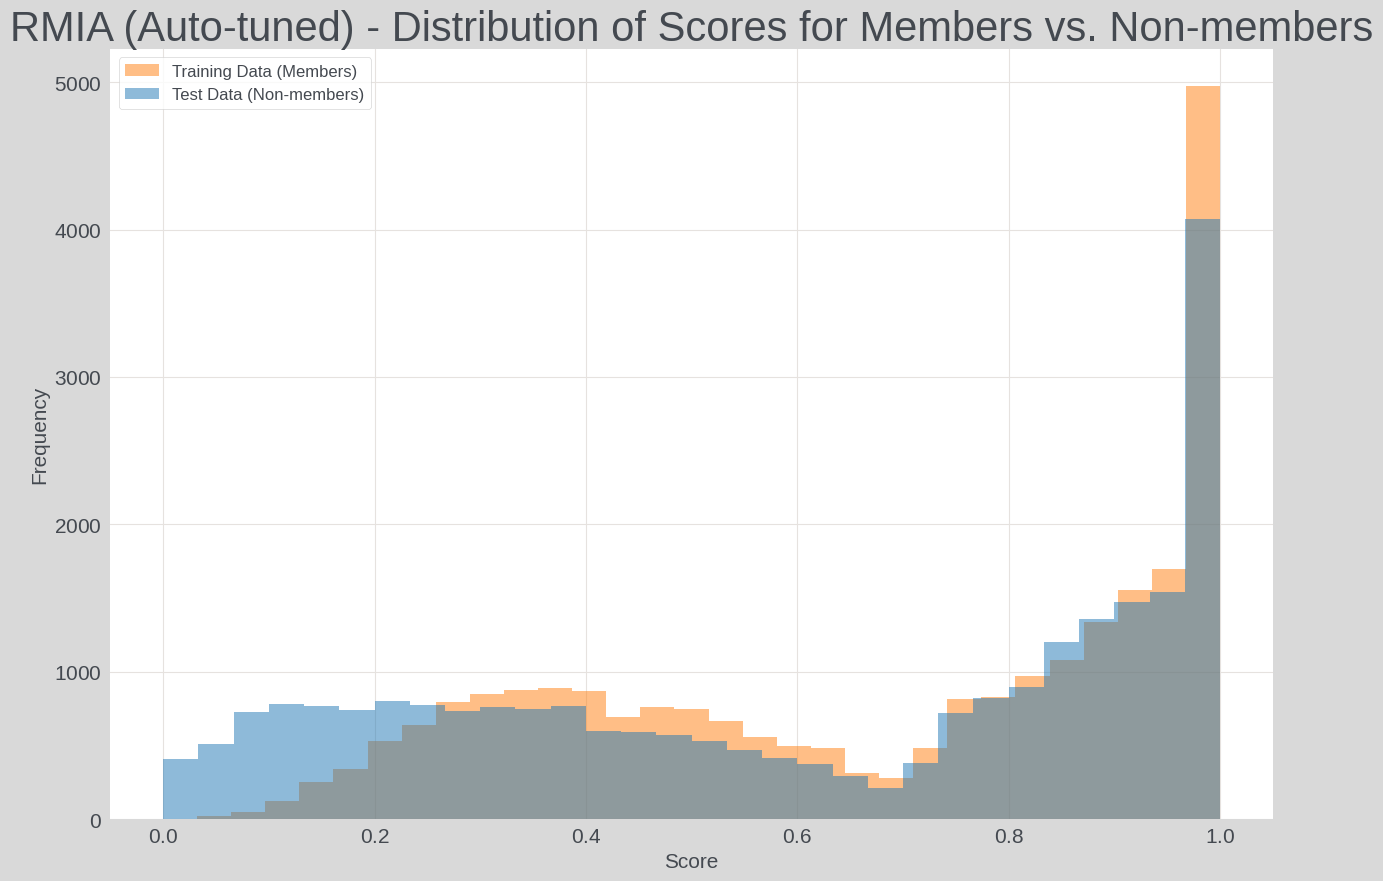

In [ ]:
# Plot score distributions for different attack configurations
plot_score_distributions(default_attack_results, "RMIA (Default Parameters)")
plot_score_distributions(tuned_attack_results, "RMIA (Auto-tuned)")


## Comparing ROC Curves

Let's compare the ROC curves for all attack variants to visualize their performance differences.

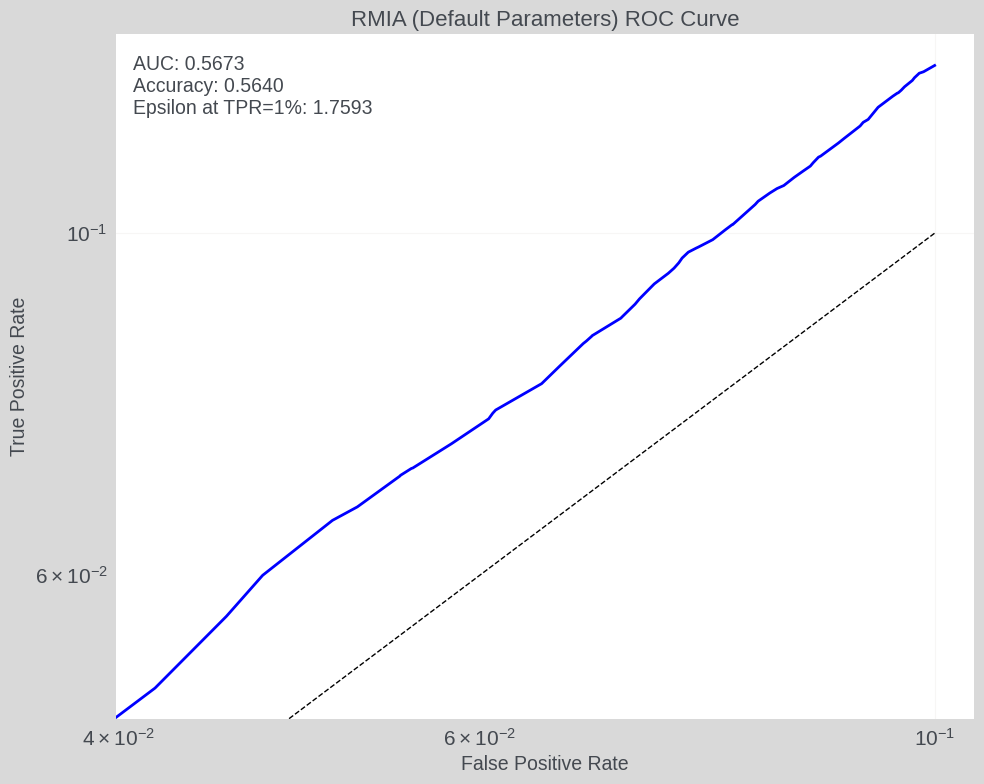

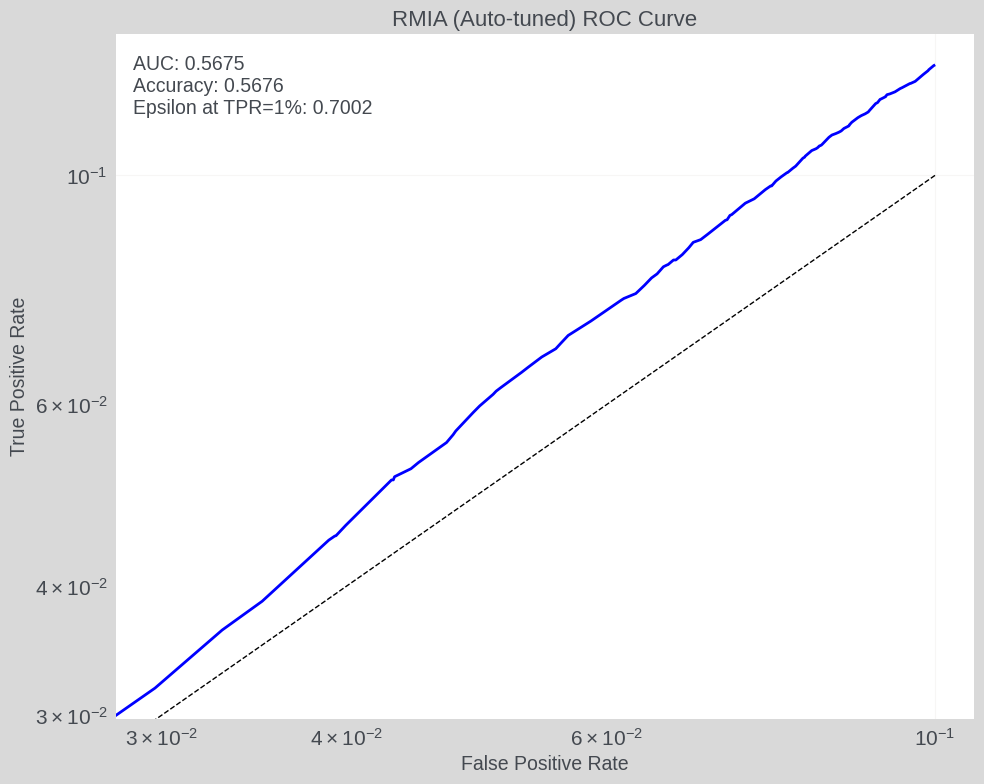

In [ ]:
plot_roc_curve(
    default_analysis, default_attack_results, title="RMIA (Default Parameters)"
)
plot_roc_curve(tuned_analysis, tuned_attack_results, title="RMIA (Auto-tuned)")

## Conclusion

In this tutorial, we demonstrated how to use the Privacy Guard framework to perform Robust Membership Inference Attacks (RMIA) on machine learning models trained on the CIFAR-10 dataset. We explored different parameter configurations and analyzed their impact on attack effectiveness.

### Key Takeaways

1. **RMIA is a sophisticated membership inference attack** that uses reference models and population data to establish baseline probability distributions for more accurate membership inference.

2. **Reference model diversity is crucial** for RMIA effectiveness. More reference models generally lead to better population probability estimates.

3. **Auto-tuning can improve performance** by automatically optimizing the alpha coefficient based on the specific dataset and model characteristics.

4. **The alpha coefficient significantly affects performance** and should be tuned for optimal results. Different datasets may require different alpha values.

5. **Population data quality matters** for establishing accurate baseline distributions. The population should be representative of the general data distribution.

### RMIA vs. Other Attacks

RMIA offers several advantages over simpler membership inference attacks:

- **More robust**: Uses multiple reference models to reduce variance in estimates
- **Population-aware**: Leverages population data to better understand baseline behavior
- **Adaptive**: Can auto-tune parameters for different scenarios
- **Ratio-based**: Uses ratio comparisons rather than simple thresholds

### Mitigating RMIA Risks

To defend against RMIA attacks, consider these approaches:

1. **Differential Privacy**: Apply differential privacy during training to limit information leakage about individual samples.

2. **Model Regularization**: Use stronger regularization to reduce overfitting and memorization of training data.

3. **Ensemble Diversity**: If using ensemble methods, ensure models are trained on sufficiently different data subsets.

4. **Output Perturbation**: Add calibrated noise to model outputs to make membership inference more difficult.

5. **Membership Hiding**: Use techniques like knowledge distillation to create models that don't directly memorize training data.

### Best Practices for Privacy Assessment

1. **Regular Privacy Auditing**: Regularly assess models using attacks like RMIA to understand privacy risks.

2. **Comprehensive Testing**: Test multiple attack variants and parameter settings to get a complete picture of vulnerabilities.

3. **Baseline Comparison**: Compare attack performance against random guessing and simpler attacks to understand the severity of risks.

4. **Real-world Scenarios**: Consider practical constraints that attackers might face, such as limited access to reference models or population data.

By understanding and addressing these privacy risks through comprehensive testing with tools like RMIA, you can build more privacy-preserving machine learning systems.